## Data

# Image Sample Points Flow Matching

This notebook is inspired by the [Flow-Matching repository](https://github.com/dome272/Flow-Matching).  
Instead of using a checkerboard pattern, we sample points from an image (for example, a cat or dogs) and use these sample points for flow matching.

**Project Organization:**

- `images/` contains the source images (e.g. `cat.png`, `dogs.jpg`).
- `models/` will store the trained model checkpoints.


/tmp/ipykernel_113868/4035562497.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path, mode='L')


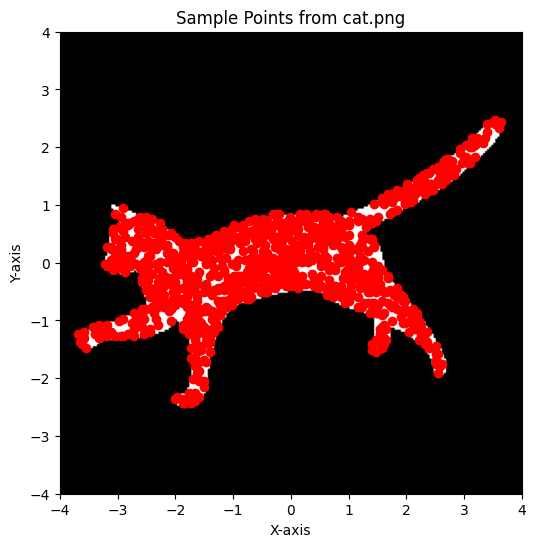

In [14]:
import os
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio

# --- Parameters ---
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4

# --- Choose Your Image ---
# Set to "dogs.jpg" to use the dogs image.
image_file = "cat.png"  
img_path = os.path.join("images", image_file)

# --- Load Image ---
# Load the image in 8-bit grayscale mode.
img = imageio.imread(img_path, mode='L')
mask = img < 128  # Adjust threshold as necessary

# Get the indices of the drawing (where mask is True)
rows, cols = np.where(mask)
img_height, img_width = img.shape

# --- Map Pixel Coordinates to (x, y) ---
x_coords = x_min + (cols / img_width) * (x_max - x_min)
# Invert rows: top row becomes y_max and bottom row becomes y_min.
y_coords = y_max - (rows / img_height) * (y_max - y_min)

# Combine into a 2D array of points
all_points = np.vstack((x_coords, y_coords)).T

# Randomly sample N points if available
if len(all_points) > N:
    indices = np.random.choice(len(all_points), size=N, replace=False)
    sampled_points = all_points[indices]
else:
    sampled_points = all_points

# --- Plot the Sampled Points ---
plt.figure(figsize=(6, 6))
# Flip the mask for imshow so it appears oriented correctly in Cartesian space.
plt.imshow(mask[::-1, :], extent=(x_min, x_max, y_min, y_max), origin="lower", cmap="gray")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title(f"Sample Points from {image_file}")
plt.show()


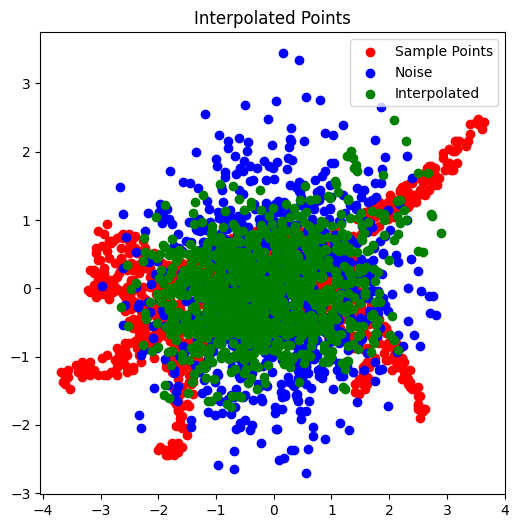

In [15]:
t = 0.5
noise = np.random.randn(N, 2)
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Sample Points")
plt.scatter(noise[:, 0], noise[:, 1], color="blue", marker="o", label="Noise")
plt.scatter((1 - t) * noise[:, 0] + t * sampled_points[:, 0], 
            (1 - t) * noise[:, 1] + t * sampled_points[:, 1], 
            color="green", marker="o", label="Interpolated")
plt.title("Interpolated Points")
plt.legend()
plt.show()


## Model

In [16]:
from torch import nn

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[Block(channels) for _ in range(layers)])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad if necessary
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x


In [17]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

## Training

In [18]:
data = torch.Tensor(sampled_points)
training_steps = 100_000
batch_size = 64

import tqdm
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())


100%|██████████| 100000/100000 [13:09<00:00, 126.72it/s, loss=2.51]


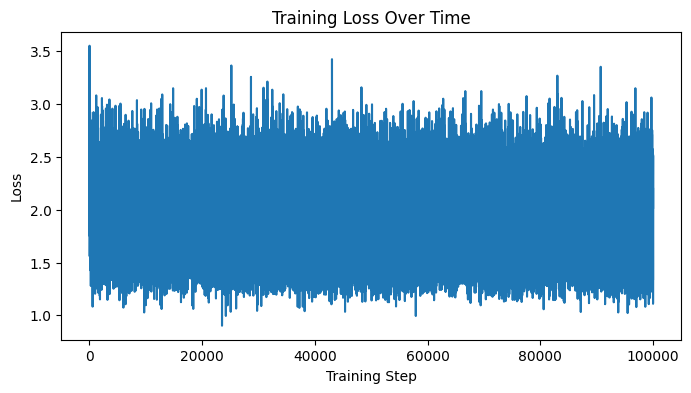

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

## Sampling

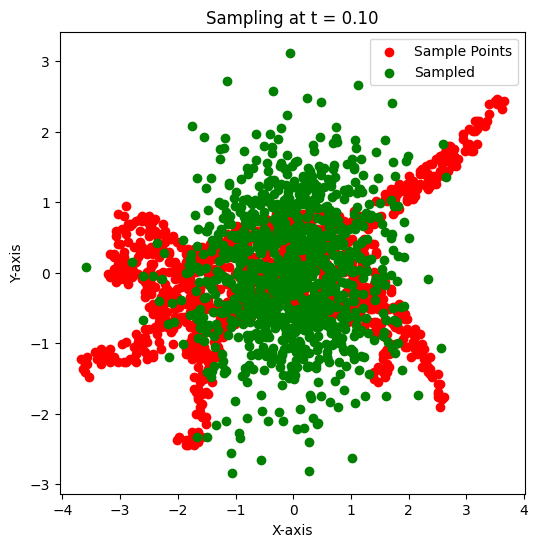

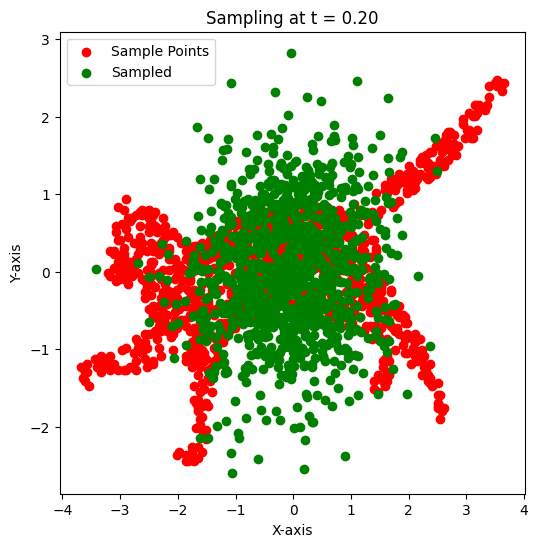

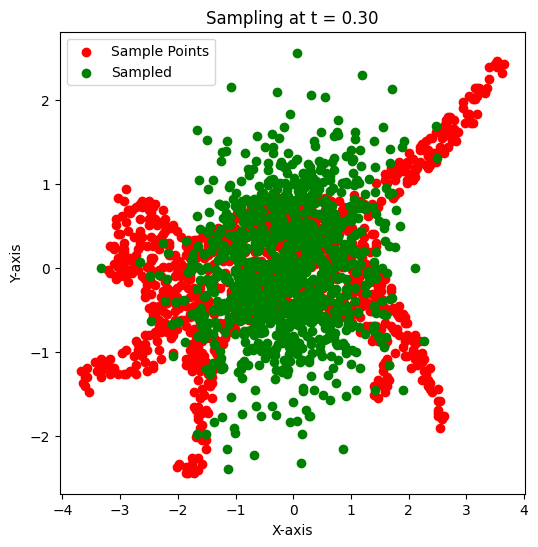

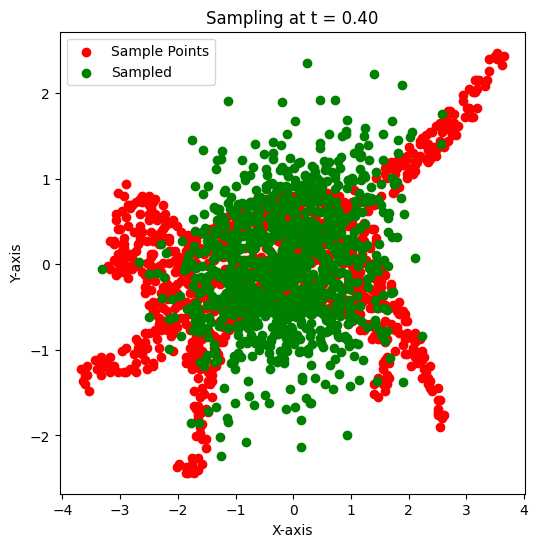

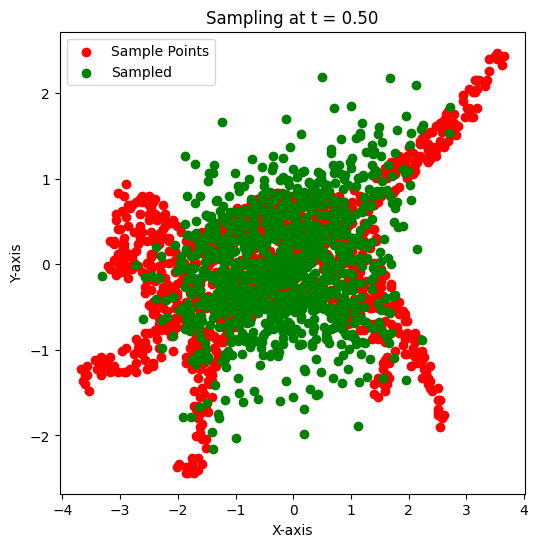

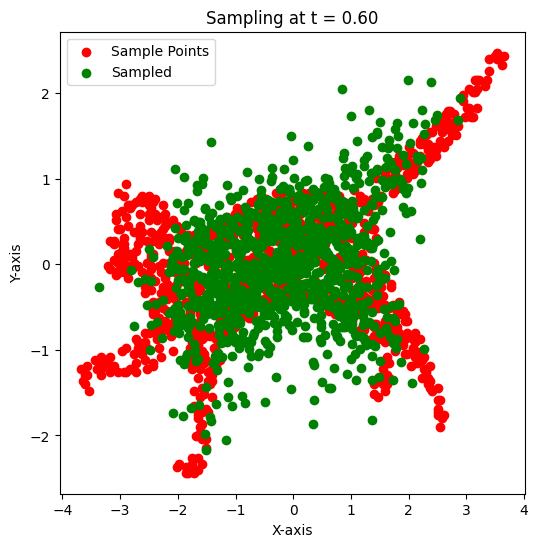

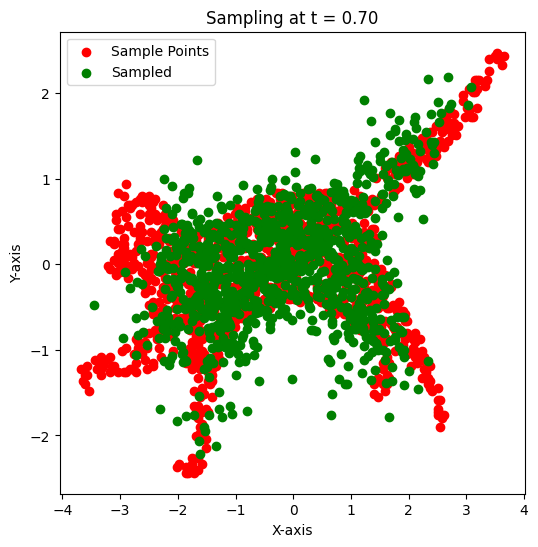

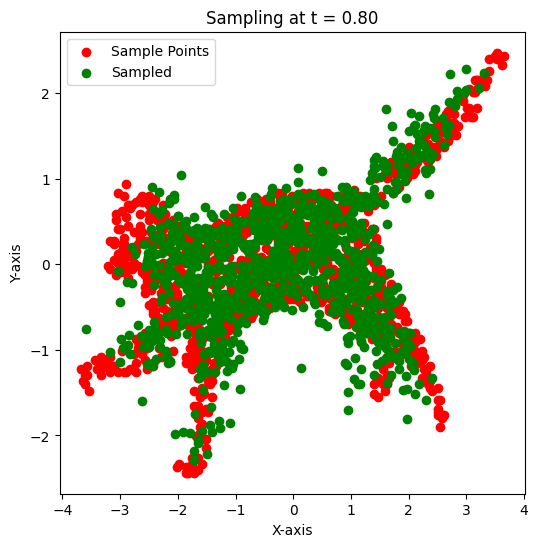

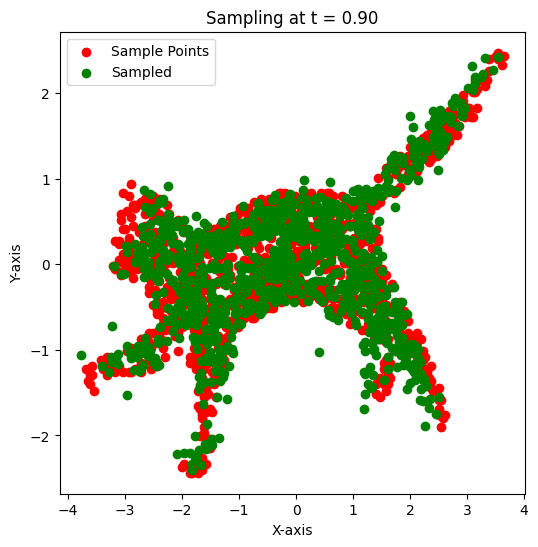

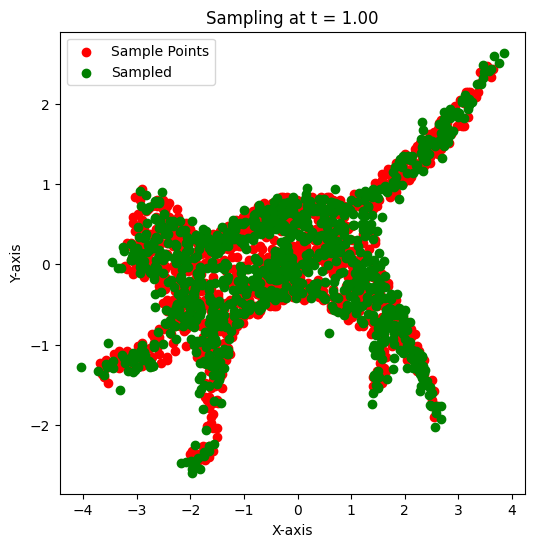

Done Sampling


In [20]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(1000, 2)
steps = 1000
plot_every = 100
for i, t_val in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t_val.expand(xt.size(0)))
    xt = xt + (1 / steps) * pred
    if i % plot_every == 0:
        plt.figure(figsize=(6, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Sample Points")
        plt.scatter(xt[:, 0], xt[:, 1], color="green", marker="o", label="Sampled")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title(f"Sampling at t = {t_val:.2f}")
        plt.legend()
        plt.show()
model.train().requires_grad_(True)
print("Done Sampling")

In [21]:
# Ensure the 'models' folder exists.
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# Save the model using a name based on the image used.
model_save_name = image_file.split('.')[0] + "_model.pt"
model_save_path = os.path.join(models_dir, model_save_name)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to models/cat_model.pt
